# System Design and my solution for the problem

In [1]:
import pandas as pd
import numpy as np

## Dummy data preparation

Since no data was provided for this task, I used a Kaggle data set located [here](https://www.kaggle.com/aerodinamicc/ecommerce-website-funnel-analysis) and modified it according to my needs in order to map it to the given coding assignment.

Relevant notebooks are located in the data_prep directory. For some of the steps, I have sampled a subset from the previous step in order to simulate a drop-off on each of the step.

## 1) Data Collection and Frontend and Backend componenets

For the scenario described in the problem, I have assumed that some sort of event tracking is implemented in the OLTP database as follows:
- Whenever a logged in user visits a certain page in the funnel, an event is populated with its user id, date, sex, channel and the page. This happens on each of the page that is part of the funnel
- For now, I have assumed it to be a single product (for e.g. insurance policy purchase) but this can be extended to multiple products as well
- Ideally, I would want each event to be tracked via some sort of a cart session so multiple sessions for a user can be tracked but this isn't the case for now

A very basic preview of the event object is given below:

In [3]:
users = pd.read_csv("data_prep/data/users.csv", index_col="user_id")
users.head()

,date,device,sex,channel
user_id,,,,
450007,2015-02-28,Desktop,Female,search
756838,2015-01-13,Desktop,Male,paid_ads
568983,2015-04-09,Desktop,Male,paid_ads
190794,2015-02-18,Desktop,Female,search
537909,2015-01-15,Desktop,Male,paid_ads


In [4]:
step1 = pd.read_csv("data_prep/data/step1.csv", index_col="user_id")
step1.head()

,page
user_id,
313593,step1
468315,step1
264005,step1
290784,step1
639104,step1


## 2) How and where would you store the data

I am envisioning this data pipeline as a distributed system that takes care of not overwhelming OLTP databases and hence the user-facing products. My idea of this pipeline and data storage is inline with the following:
- OLTP database such as MySQL that stores application data. That also funnel event data
- Spark jobs to batch load events from OLTP on a nightly basis and put them into parquet file format into what I call a Data Lake. All jobs are scheduled via Airflow. This is for the most part, raw unprocessed data stored in a file system analogous to Hadoop
- My implemented Spark jobs are not fully production ready. Ideally, I would add some partitioning and throttling on my Spark jobs to make sure they don't bring down the OLTP and are capable of extracting deltas rather than doing a full load of the table every time
- Data Lake enables us to offload load from OLTP and gives us a rather unbounded plane to extract, slice and dice data, rinse and repeat, etc.
- Once we have the data in Data Lake, we can model it to however we want. This can be based on a teams need. In my case, I am applying some very basic dimension modeling and expanding it to make my queries simpler and easier to follow
- Modeling is performed by Spark jobs (scheduled via Airflow) that load data from Data Lake and generate new dimension model tables. My understanding is that these dimension models can then be loaded into Snowflake or Redshift so that downstream teams can slice and dice data. Sample queries on dimension models are shown later in this notebook

### Airflow DAG dependencies

It's worth noticing that modeling jobs have to wait until the Data Lake extraction is complete. To make that possible, I have modeled DAGs in Airflow to take care of that using `ExternalTaskSensor` which waits for the previous DAG to complete before it starts the downstream DAG. I find this technique very useful for modeling data flows like this.

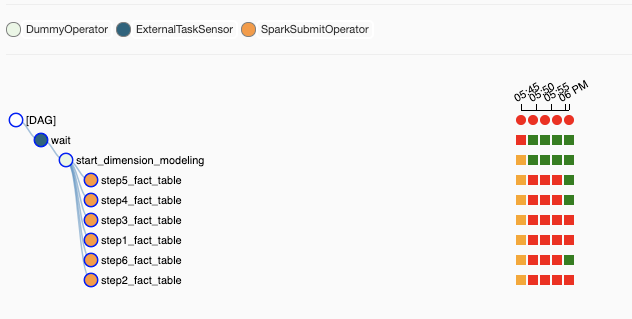

## 3) How will you generate Funnel Analysis